In [1]:
from cobra.io import read_sbml_model
from utils.flux_coupling import add_ratio_constraint_cobra

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

## Dynamic simulation (2-phase M5 / M5 + solventogenic NJ4)
sequential community

### Constraining the individual models:

NJ4:  
constrained to solventogenesis state

In [2]:
# restrict reaction reversibility

reactions = ["ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", 
             "ADCi", "PTAr", "POR_syn", "FNOR", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f",] #ABE pathway

KO_rx = ["XYLANabc", "GLCURS1"] #xylan uptake reactions

for rx in reactions:
    nj4.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4.reactions.get_by_id(rx).bounds = (-1000, 0)

for rx in KO_rx:
    nj4.reactions.get_by_id(rx).bounds = (0, 0)

# TCA cycle
#nj4_acido.reactions.SUCD2.bounds = (-1000, 1000) #only relevant if doing 3-step with acido and solvento models

# "closing off" reductive TCA for solventogenesis
nj4.reactions.SUCD2.bounds = (-1000, 0)
nj4.reactions.MDH.bounds = (-1000, 0)

# knock out reactions for acetate and butyrate production
nj4.reactions.ACtr.bounds = (0, 1000)
nj4.reactions.BUTt.bounds = (0, 1000)

# flux coupling but/ac uptake for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4, "BUTt" , "ACtr",  0.42, r_num_reverse=True, r_den_reverse=True)

# flux coupling btoh/acetone production for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

Metabolite identifier,ratio_BTOHt_ACEt
Name,
Memory address,0x128df0640
Formula,None
Compartment,pseudo
In 2 reaction(s),"ACEt, BTOHt"


In [3]:
# define the Specific Proton Flux (SPF) property

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

# as a constraint
SPF_constraint = nj4.problem.Constraint(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        lb=0.2,
        ub=5)

# as an objective
SPF_obj = nj4.problem.Objective(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

#nj4.objective = SPF_obj
nj4.add_cons_vars(SPF_constraint)

M5

In [27]:
# knock out reactions for xylose uptake
uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]

for rx in uptake_KO:
    m5.reactions.get_by_id(rx).bounds = (0, 0)

# restrict the max rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.5)

# restrict uptake of butanol
m5.reactions.BTOHt.bounds = (-1000, 0)

# constrain butyrate / acetate production ratio to exp. measurement
add_ratio_constraint_cobra(m5, "BUTt" , "ACtr",  0.71, r_num_reverse=False, r_den_reverse=False)

Metabolite identifier,ratio_BUTt_ACtr
Name,
Memory address,0x12c28b700
Formula,None
Compartment,pseudo
In 2 reaction(s),"BUTt, ACtr"


In [28]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

VOLUME = 0.05
MM_XYLAN8 = 1201.04
xylan_concentration = 70 #g/L

added_metabilotes["xylan8_e"] = (xylan_concentration * VOLUME / MM_XYLAN8) * 1000
added_metabilotes["xylan4_e"] = 0

In [35]:
from utils.kinetic_params import KINETIC_PARAMS

KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 0.8
KINETIC_PARAMS["M5"]["km"]["EX_xyl__D_e"] = 10
# KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 6

KINETIC_PARAMS["NJ4"]["km"]["EX_xyl__D_e"] = 0.25
#KINETIC_PARAMS["NJ4"]["vmax"]["EX_xyl__D_e"] = 6

INOC_TIME = 50

In [36]:
# AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
#                 "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
#                 "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]

# for strain in KINETIC_PARAMS.keys():
#     for rx in AA_uptake_rx:
#         KINETIC_PARAMS[strain]["km"][rx] = 0.5

In [37]:
from utils import comets_functions as cf
from utils.kinetic_params import KINETIC_PARAMS

first_sim, second_sim = cf.sequental_com(m5, nj4, init_medium=added_metabilotes, kinetic_params=KINETIC_PARAMS, inoc_time=INOC_TIME, inoc_ratio=1)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


### simulation

In [4]:
from utils.kinetic_params import KINETIC_PARAMS

KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 1
KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 6

In [38]:
bm, met, fluxes = cf.collapse_sequential_sim(first_sim, second_sim)

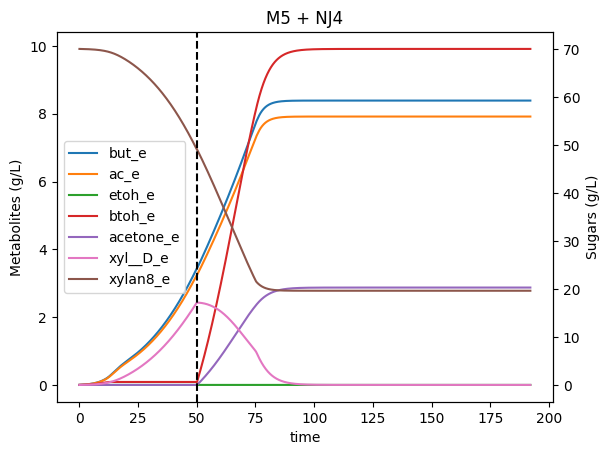

In [42]:
metabolites = ["but_e",  "ac_e", "etoh_e", "btoh_e", "acetone_e", "xyl__D_e", "xylan8_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME)

import matplotlib.pyplot as plt
# plt.title("M5 + NJ4")
# plt.savefig("figures/community.svg", format="svg")

In [32]:
# find the metablites from the medium which runs out at some point
suspects = [met for met in added_metabilotes.keys() if met in second_sim.get_metabolite_time_series().columns]
suspect_df = second_sim.get_metabolite_time_series()[suspects]
suspect_df.loc[:, suspect_df.iloc[-1] == 0]

metabolite,dcyt_e
0,5.981177e-24
1,4.351974e-24
2,3.161527e-24
3,2.293059e-24
4,1.660496e-24
...,...
1416,0.000000e+00
1417,0.000000e+00
1418,0.000000e+00
1419,0.000000e+00


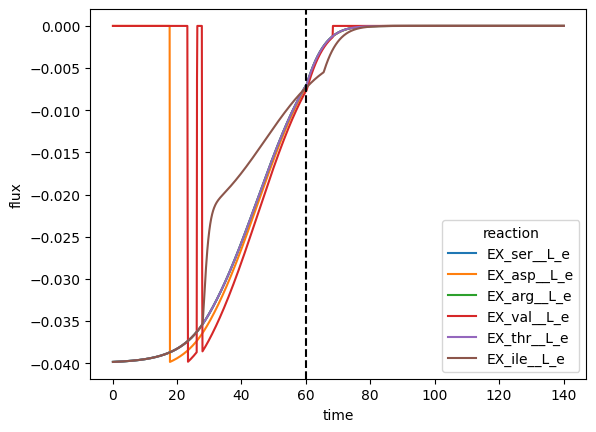

In [24]:
cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=["EX_" + aa for aa in amino_acids], inoc_time=INOC_TIME)

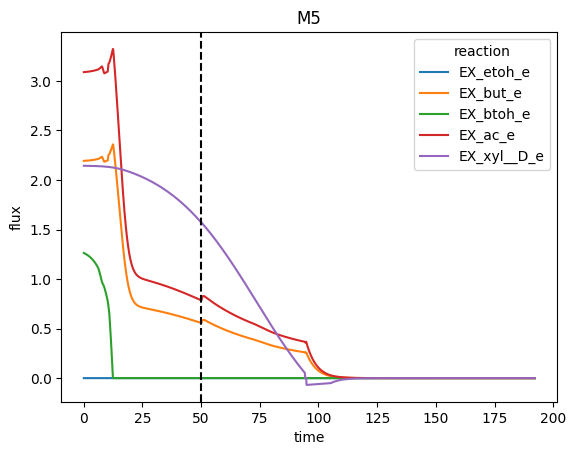

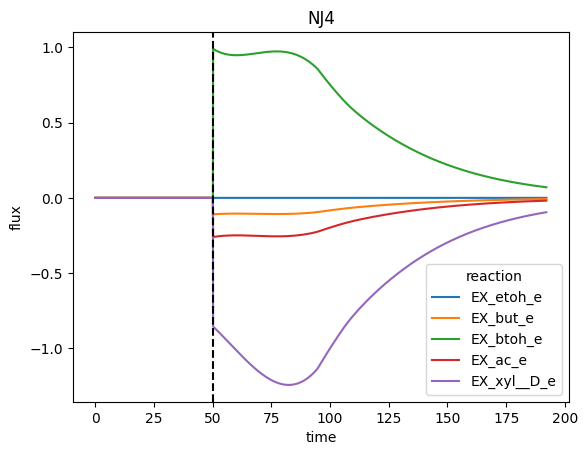

In [21]:
import matplotlib.pyplot as plt

production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('M5')
plt.show()

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.title('NJ4')
plt.show()

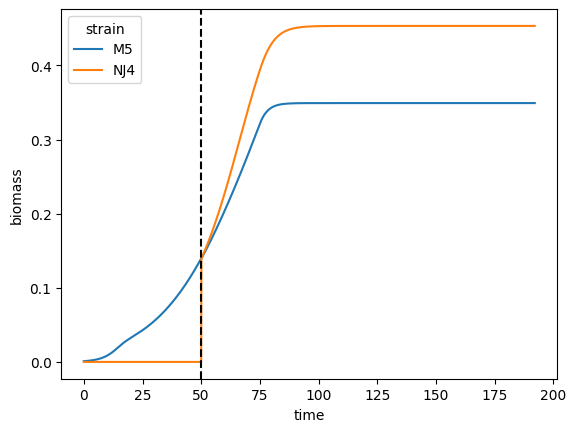

In [40]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)

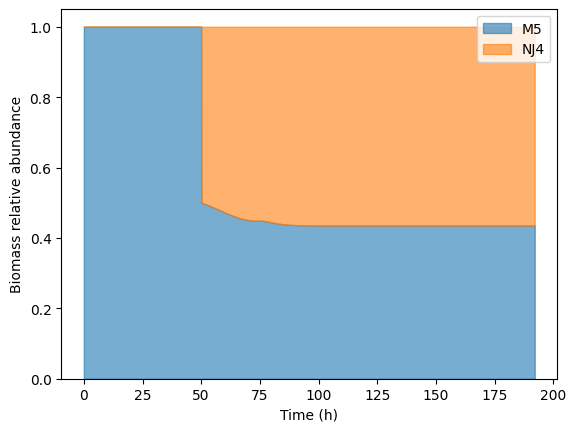

In [41]:
cf.plot_relative_abundance(total_biomass=bm)

## Dynamic simulation (3-phase M5/ M5 + acidogenic NJ4 / M5 + solventogenic NJ4)

### Loading and constraining the M5 and NJ4 models

In [10]:
from cobra.io import read_sbml_model
from utils.flux_coupling import add_ratio_constraint_cobra

nj4 = read_sbml_model("GEMs/NJ4_curated.xml")
m5 = read_sbml_model("GEMs/M5_curated.xml")

In [11]:
# M5

uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]

for rx in uptake_KO:
    m5.reactions.get_by_id(rx).bounds = (0, 0)

# restrict rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.4)

# restrict uptake of butanol
m5.reactions.BTOHt.bounds = (-1000, 0)

from utils.flux_coupling import add_ratio_constraint_cobra

# flux coupling constraint forcing but/ac production to exp. values
add_ratio_constraint_cobra(m5, "BUTt" , "ACtr",  0.71, r_num_reverse=False, r_den_reverse=False)

reactions = ["ACACT1r", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", 
            "PTAr", "POR_syn", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "ACKr", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f", #ABE pathway
                      ]

for rx in reactions:
    m5.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    m5.reactions.get_by_id(rx).bounds = (-1000, 0)


In [12]:
# nj4
# define the Specific Proton Flux (SPF) property

h_membrane_rx = [r.id for r in nj4.metabolites.h_e.reactions if "EX" not in r.id]

neg_stoich = []
pos_stoich = []

for rx in h_membrane_rx:
    stociometry = {met.id:coeff for met, coeff in nj4.reactions.get_by_id(rx).metabolites.items()}    
    if stociometry["h_e"] < 0:
        pos_stoich.append(rx)
    elif stociometry["h_e"] > 0:
        neg_stoich.append(rx)

# as an objective
SPF_obj = nj4.problem.Objective(
        sum([nj4.reactions.get_by_id(rx).flux_expression for rx in pos_stoich]) - sum([nj4.reactions.get_by_id(rx).flux_expression for rx in neg_stoich]),
        direction="max")

nj4_acido = nj4.copy()
nj4_solvento = nj4.copy()

# restrict reaction reversibility

reactions = ["ACACT1r", "HACD1", "ECOAH1", "ACOAD1fr", "ACOAD1", "BTCOARx", "PBUTT", 
             "ADCi", "PTAr", "POR_syn", "FNOR", "FNRR","T2ECR", "BNOCA", #ABE pathway
             ]

reverse_reactions = ["ALCD4", "BUTKr", "BUTCT2", "ACKr", "ACACCT", "ACALD",
                      "HYDA", "HACD1i", "ACOAD1fr", "ACOAD1f", #ABE pathway
                      ]

KO_rx = ["XYLANabc", "GLCURS1"] #xylan uptake reactions

for rx in reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 1000)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 1000)

for rx in reverse_reactions:
    nj4_acido.reactions.get_by_id(rx).bounds = (-1000, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (-1000, 0)

for rx in KO_rx:
    nj4_acido.reactions.get_by_id(rx).bounds = (0, 0)
    nj4_solvento.reactions.get_by_id(rx).bounds = (0, 0)

# TCA cycle
nj4_acido.reactions.SUCD2.bounds = (-1000, 1000)

# "closing off" reductive TCA for solventogenesis
nj4_solvento.reactions.SUCD2.bounds = (-1000, 0)
nj4_solvento.reactions.MDH.bounds = (-1000, 0)
# nj4_solvento.reactions.FUM.bounds = (-1000, 0)

# knock out reactions for acetate and butyrate production
nj4_solvento.reactions.ACtr.bounds = (0, 1000)
nj4_solvento.reactions.BUTt.bounds = (0, 1000)

from utils.flux_coupling import add_ratio_constraint_cobra

# flux coupling but/ac production for acidogeneis to exp. value
add_ratio_constraint_cobra(nj4_acido, "BUTt" , "ACtr",  1.02, r_num_reverse=True, r_den_reverse=True)

# flux coupling btoh/acetone production for solventogenesis to exp. value
add_ratio_constraint_cobra(nj4_solvento, "BTOHt" , "ACEt",  2.68, r_num_reverse=True, r_den_reverse=False)

# add SPF objectove to solventogen model
nj4_solvento.objective = SPF_obj

### Sequential simulation

In [13]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

VOLUME = 0.05
MM_XYLAN8 = 1201.04
xylan_concentration = 70 #g/L

added_metabilotes["xylan8_e"] = (xylan_concentration * VOLUME / MM_XYLAN8) * 1000
added_metabilotes["xylan4_e"] = 0

In [14]:
from utils.kinetic_params import KINETIC_PARAMS

In [27]:
# updated the kinetic params file - this should no longer be necessary
# AA_uptake_rx = ["EX_val__L_e", "EX_arg__L_e", "EX_asp__L_e", "EX_dhptd_e", "EX_glu__L_e", "EX_ile__L_e", "EX_ser__L_e", 
#                 "EX_thr__L_e", "EX_ala__L_e", "EX_cys__L_e", "EX_gly_e", "EX_his__L_e", "EX_leu__L_e", 
#                 "EX_met__L_e", "EX_phe__L_e", "EX_pro__L_e", "EX_tyr__L_e", "EX_trp__L_e", "EX_lys__L_e"]

# for strain in KINETIC_PARAMS.keys():
#     for rx in AA_uptake_rx:
#         KINETIC_PARAMS[strain]["km"][rx] = 1

In [15]:
# using exact same parameters as in the individual sims

# restrict rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.35)#0.8)

# nj4 kinetic params
# all default / from param list

# KINETIC_PARAMS["NJ4"]["km"]["EX_xyl__D_e"] = 1
# KINETIC_PARAMS["NJ4"]["vmax"]["EX_xyl__D_e"] = 6

#m5 kinetic params
KINETIC_PARAMS["M5"]["km"]["EX_xylan8_e"] = 0.9 #1
KINETIC_PARAMS["M5"]["vmax"]["EX_xylan8_e"] = 10

KINETIC_PARAMS["M5"]["km"]["EX_xyl__D_e"] = 10
KINETIC_PARAMS["M5"]["vmax"]["EX_xyl__D_e"] = 2

In [16]:
m5_cold = m5.copy()
#m5_cold.reactions.ATPM.bounds = (0.1, 1000)

#m5_cold.reactions.XYLt2.bounds = (0, 0.2)

In [17]:
INOC_TIME = 50

In [18]:
from copy import deepcopy

kinetic_params_cold = deepcopy(KINETIC_PARAMS)
kinetic_params_cold["M5"]["km"]["EX_xylan8_e"] = 1.5 # 1.5
kinetic_params_cold["M5"]["vmax"]["EX_xylan8_e"] = 8

In [11]:
from utils import comets_functions as cf

first_sim, second_sim, third_sim = cf.sequential_with_switch(m5=m5, nj4_acido=nj4_acido, nj4_solvento=nj4_solvento, m5_cold=m5_cold, init_medium=added_metabilotes, 
                                                             kinetic_params=KINETIC_PARAMS, inoc_time=INOC_TIME, initial_pop_m5=0.0005, kinetic_params_cold=kinetic_params_cold)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [12]:
bm, met, fluxes = cf.collapse_three_sim(first_sim, second_sim, third_sim)

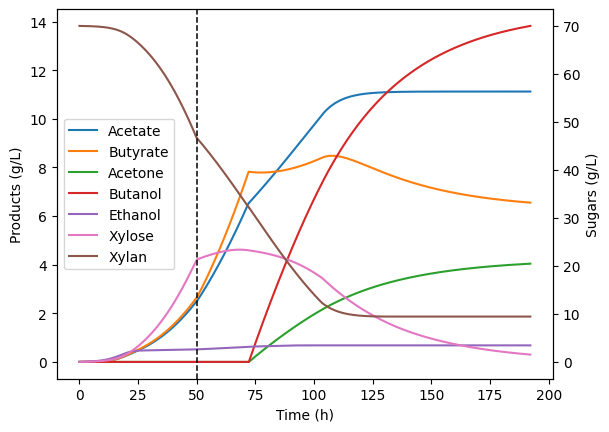

In [14]:
metabolites = ["xyl__D_e", "xylan8_e", "ac_e", "but_e",  "acetone_e", "btoh_e",  "etoh_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=INOC_TIME, use_molar_amount=False, common_names=True)

import matplotlib.pyplot as plt
plt.savefig("figures/community.svg", format="svg")

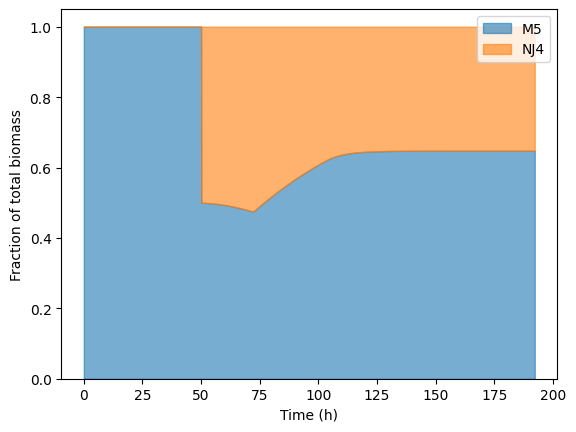

In [15]:
cf.plot_relative_abundance(total_biomass=bm)

# import matplotlib.pyplot as plt
plt.savefig("figures/community_ra.svg", format="svg")

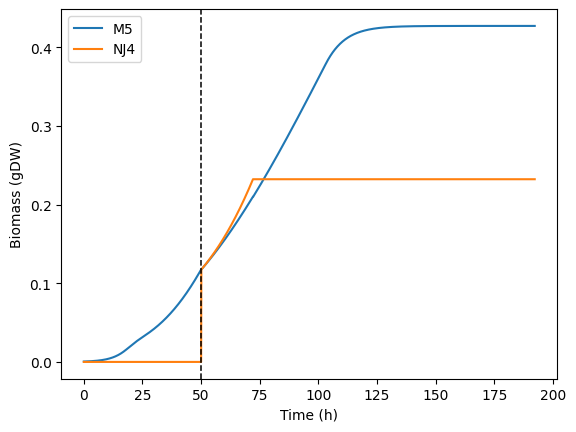

In [16]:
cf.plot_biomass(total_biomass=bm, inoc_time=INOC_TIME)
plt.savefig("figures/community_bm.svg", format="svg")

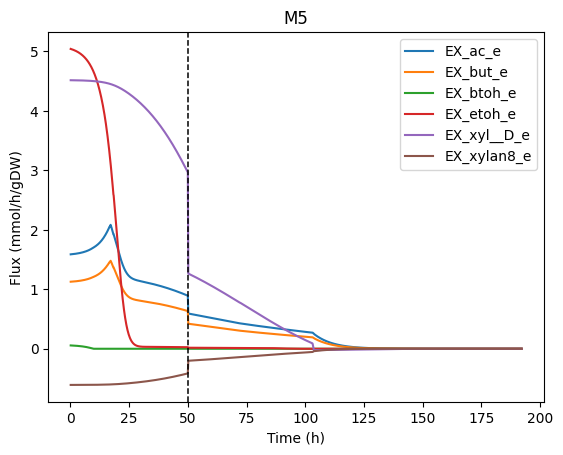

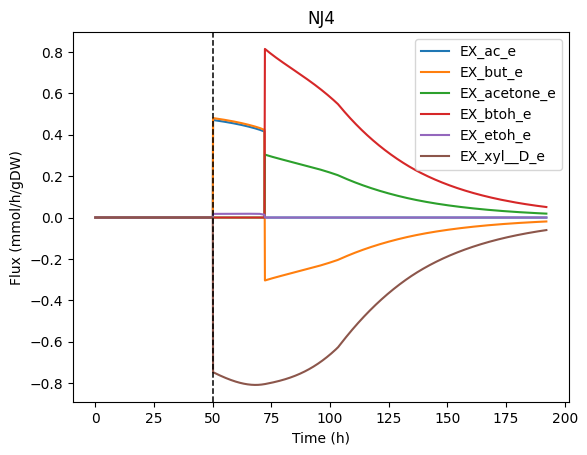

In [21]:
import matplotlib.pyplot as plt

production_reactions = ["EX_ac_e", "EX_but_e", "EX_btoh_e", "EX_etoh_e", "EX_xyl__D_e", "EX_xylan8_e"]


cf.plot_reaction_flux(fluxes=fluxes["M5"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.savefig("figures/community_flux_M5.svg", format="svg")
plt.title('M5')
plt.show()

production_reactions = ["EX_ac_e", "EX_but_e", "EX_acetone_e", "EX_btoh_e", "EX_etoh_e", "EX_xyl__D_e"]

cf.plot_reaction_flux(fluxes=fluxes["NJ4"], reactions=production_reactions, inoc_time=INOC_TIME);
plt.savefig("figures/community_flux_NJ4.svg", format="svg")
plt.title('NJ4')
plt.show()

### Simulation with automated acidogenesis / solventogenesis switch-point

In [20]:
VOLUME = 0.05
MM_XYLAN8 = 1201.04
xylan_concentration = 80 #g/L

added_metabilotes["xylan8_e"] = (xylan_concentration * VOLUME / MM_XYLAN8) * 1000

In [25]:
from utils import comets_functions as cf

first_sim, second_sim, third_sim = cf.sequential_with_switch(m5=m5, nj4_acido=nj4_acido, nj4_solvento=nj4_solvento, m5_cold=m5_cold, init_medium=added_metabilotes, 
                                                  kinetic_params=KINETIC_PARAMS, inoc_time=84, find_switch_time=True, kinetic_params_cold=kinetic_params_cold,
                                                  inoc_ratio=2.0)


Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!

Running COMETS simulation ...
Done!


In [26]:
bm, met, fluxes = cf.collapse_three_sim(first_sim, second_sim, third_sim)

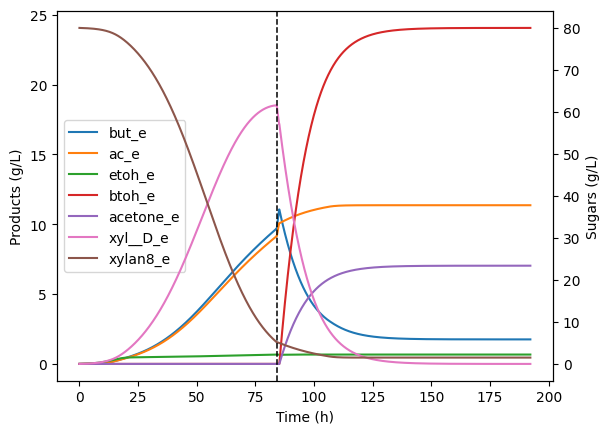

In [28]:
metabolites = ["but_e",  "ac_e", "etoh_e", "btoh_e", "acetone_e", "xyl__D_e", "xylan8_e"]

cf.plot_metabolites(metabolites_time_series=met, metabolites=metabolites, inoc_time=84, use_molar_amount=False)

## Fermentation parameter optimisation

In [4]:
import pandas as pd

df1 = pd.read_csv("grid_search_results/grid_search_result_Mar_20_1133.csv")
df2 = pd.read_csv("grid_search_results/grid_search_result_Mar_20_1441.csv")
df3 = pd.read_csv("grid_search_results/grid_search_result_Mar_20_1744.csv")
df4 = pd.read_csv("grid_search_results/grid_search_result_Mar_21_2316.csv")
# df5 = pd.read_csv("grid_search_results/grid_search_result_Mar_22_1722.csv")
# df6 = pd.read_csv("grid_search_results/grid_search_result_Mar_22_2214.csv")
df7 = pd.read_csv("grid_search_results/grid_search_result_Mar_23_2325.csv")

In [5]:
df = pd.concat([df1, df2, df3, df4, df7])
df.reset_index(drop=True, inplace=True)

In [6]:
from utils import unit_conversion

df["Butanol (g/L)"] = unit_conversion.mmol_to_g_per_L("btoh_e", df["butanol"])

In [10]:
df.to_csv("grid_search_results/final_res.csv", index=False)

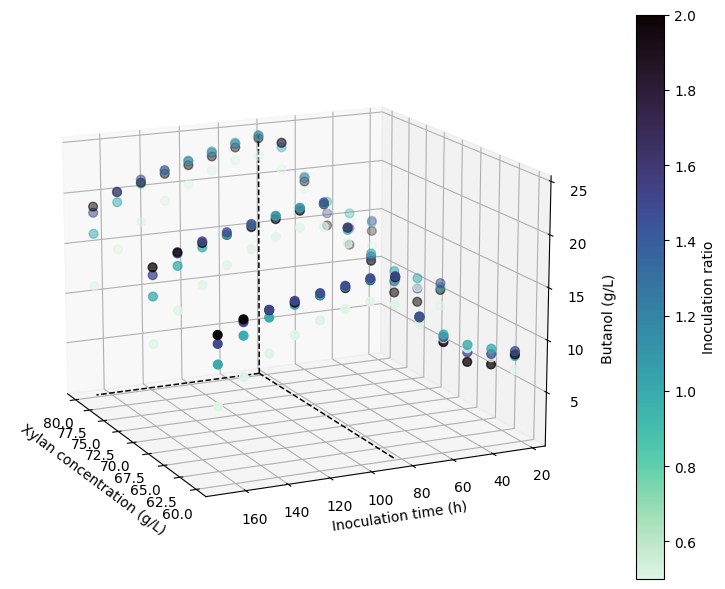

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.colors as mcolors

x = df["xylan_conc"]
y = df["inoc_time"]
c = df["inoc_ratio"]
z = df["Butanol (g/L)"]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_zlim([0.3,25]) # a hack to make it look like the x-y is at z=0

# this is important in order to get discrete colors on inoc_ratio
#norm = mcolors.BoundaryNorm(boundaries=np.unique(c), ncolors=len(c.unique()))

# Scatter plot with 'inoc_ratio' as color
sc = ax.scatter(x, y, z, c=c, s=40, cmap="mako_r") #, cmap="tab10", norm=norm)

ax.set_xlabel('Xylan concentration (g/L)')
ax.set_ylabel('Inoculation time (h)')
ax.set_zlabel('Butanol (g/L)')

#fig.legend(handles=sc.legend_elements()[0], labels=list(c.unique()), title="Inoculation ratio", loc="upper right")

cbar = fig.colorbar(sc, pad=.08)
cbar.set_label('Inoculation ratio')

sc._axes.view_init(elev=15, azim=155)

# add helper lines to the max point
max_z_index = np.argmax(z)
max_z_x = x[max_z_index]
max_z_y = y[max_z_index]
max_z = z[max_z_index]

ax.plot([max_z_x, max_z_x], [max_z_y, max_z_y], [0, max_z], color='black', linestyle='dashed', linewidth=1.1) # from point down to x/y plane
ax.plot([min(x), max(x)], [max_z_y, max_z_y], zs=0, color='black', linestyle='dashed', linewidth=1.1) # from x/y plane to y axis
ax.plot([max_z_x, max_z_x], [max_z_y, max(y)], zs=0, color='black', linestyle='dashed', linewidth=1.1) # from x/y plane to x axis

plt.tight_layout()

#plt.savefig("figures/ferm_opt_3d.svg", format="svg")

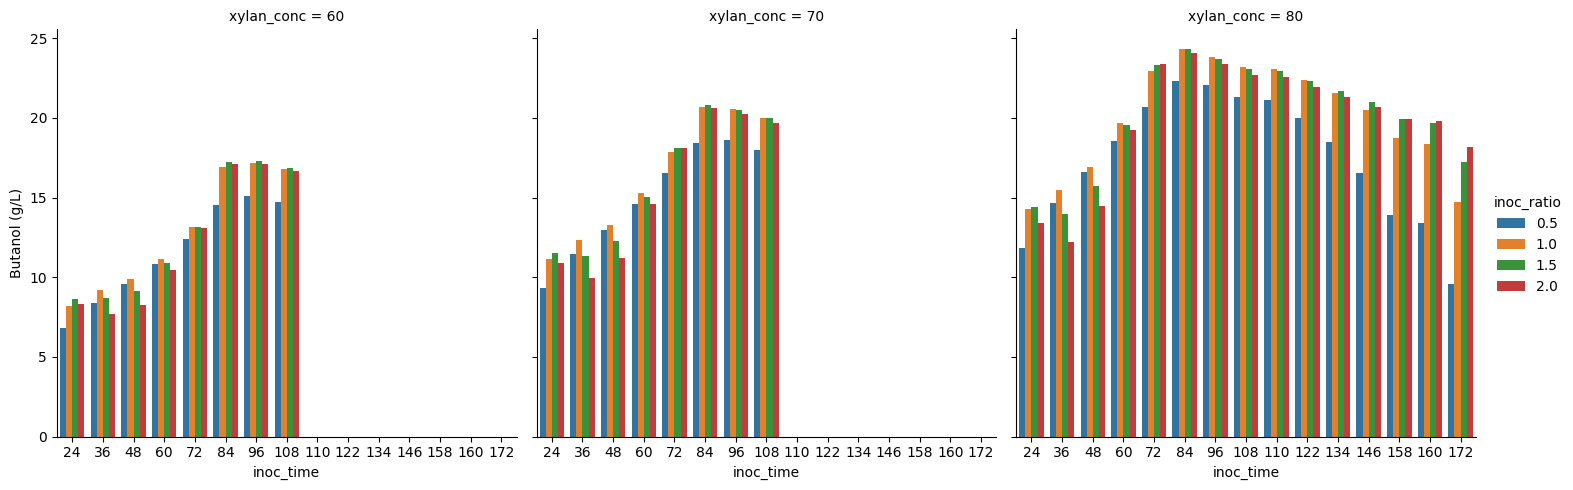

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(x="inoc_time" , hue="inoc_ratio" , col='xylan_conc', y="Butanol (g/L)", kind="bar", data=df)

#plt.savefig("figures/ferm_opt.svg", format="svg")

Text(50.722222222222214, 0.5, 'Inoculation ratio')

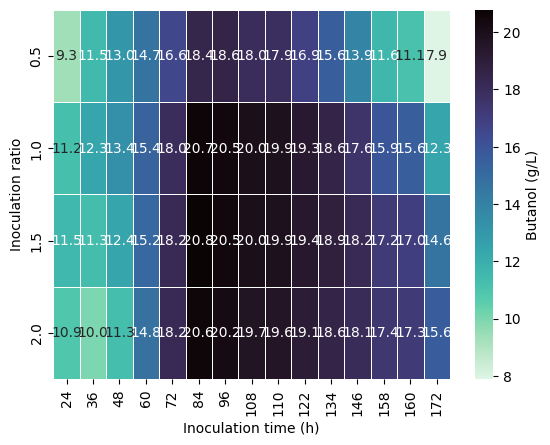

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot_df = df.pivot_table(index='inoc_ratio', columns='inoc_time', values='Butanol (g/L)', aggfunc="mean")
sns.heatmap(pivot_df, annot=True, linewidth=.5, cbar_kws={'label': 'Butanol (g/L)'}, cmap="mako_r", fmt=".1f")
plt.xlabel('Inoculation time (h)')
plt.ylabel('Inoculation ratio')

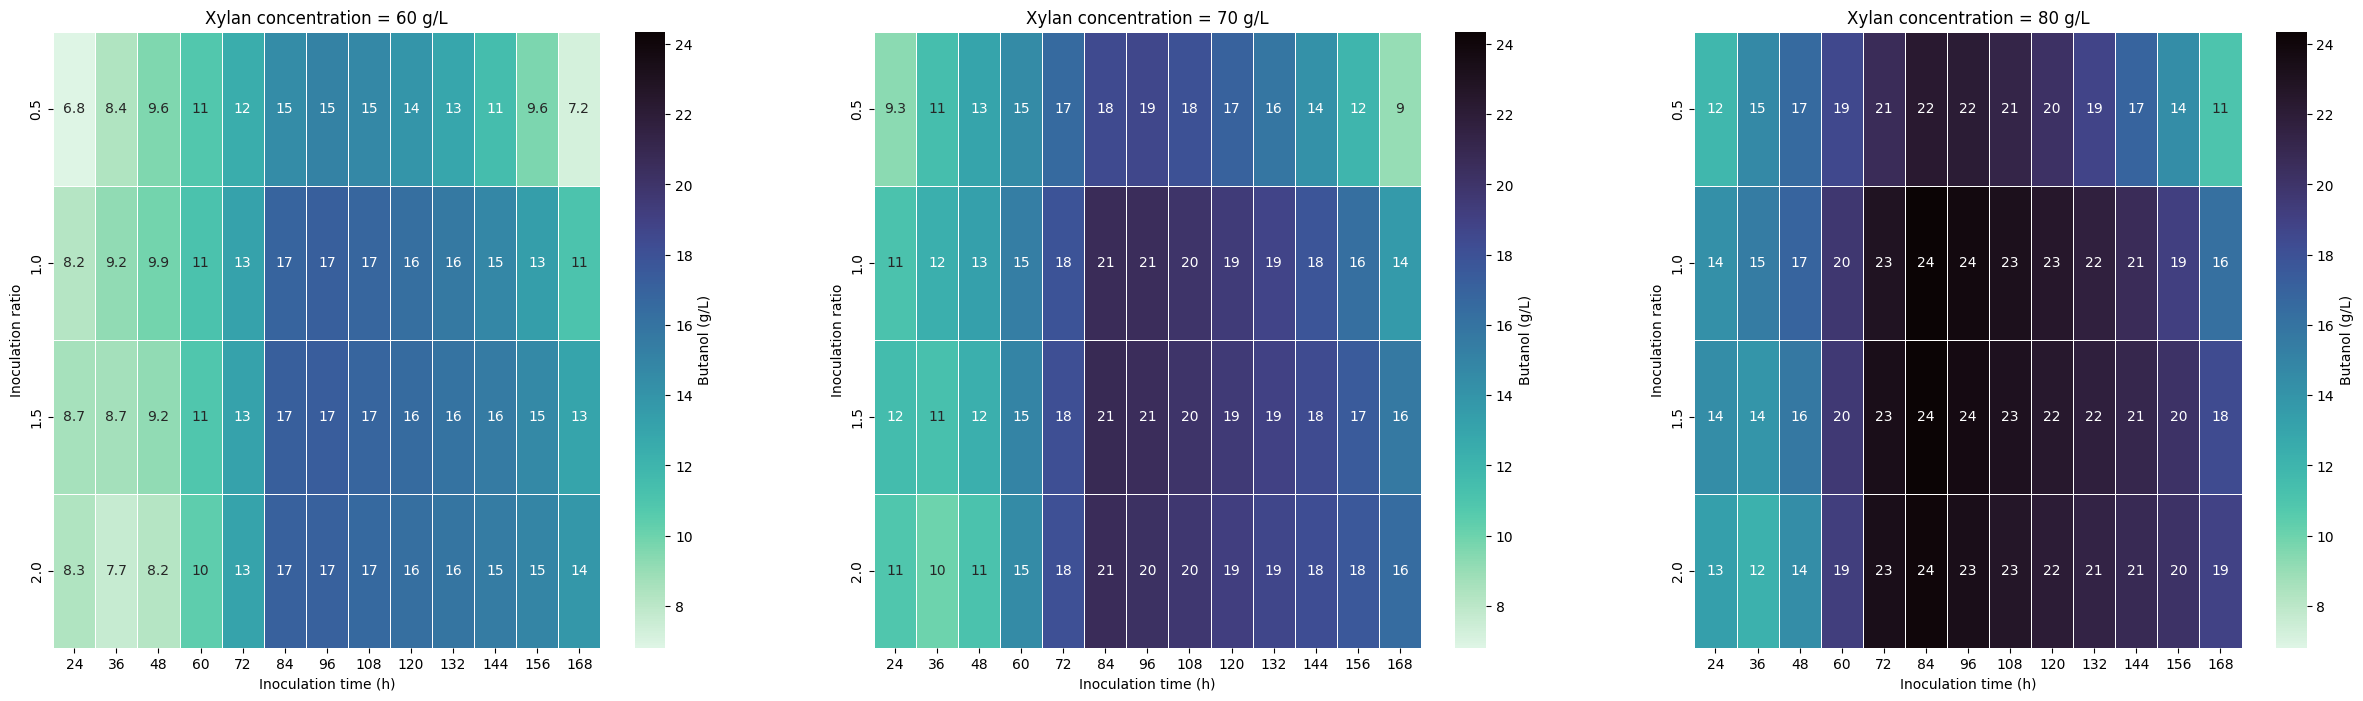

In [9]:
# Get unique values of 'xylan_conc'
xylan_values = [60, 70, 80]

# Determine global min and max 'Butanol (g/L)' values across all subsets of the DataFrame
global_min = df['Butanol (g/L)'].min()
global_max = df['Butanol (g/L)'].max()

# Create a figure and set its size
plt.figure(figsize=(30, 8))

# Create a heatmap for each unique value of 'xylan_conc'
for i, xylan in enumerate(xylan_values):
    subset_df = df[df['xylan_conc'] == xylan]
    pivot_df = subset_df.pivot_table(index='inoc_ratio', columns='inoc_time', values='Butanol (g/L)')
    
    # Create a subplot for each heatmap
    plt.subplot(1, len(xylan_values), i+1)
    sns.heatmap(pivot_df, annot=True, linewidth=.5, cbar_kws={'label': 'Butanol (g/L)'}, cmap="mako_r", vmin=global_min, vmax=global_max) #,fmt=".1f")
    plt.title(f'Xylan concentration = {xylan} g/L')
    plt.xlabel('Inoculation time (h)')
    plt.ylabel('Inoculation ratio')

plt.savefig("figures/ferm_opt_heatmap.svg", format="svg")
plt.show()